In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import fxcmpy
from fxcmpy import fxcmpy_tick_data_reader as tdr
import tables as tb
import GPy

In [3]:
def plot_fit(x,y,mu,var, m_y='k-o', m_mu='b-<', l_y='true', l_mu='predicted', legend=True, title=''):
    """
    Plot the fit of a GP
    """
    if y is not None:
        plt.plot(x,y, m_y, label=l_y)
    plt.plot(x,mu, m_mu, label=l_mu)
    vv = 2*np.sqrt(var)
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
    if legend:
        plt.legend()
    if title != '':
        plt.title(title)

In [4]:
# devide data into N parts in order to calculate the average of N parts
def chunk(y, N): 
    n = int(len(y)/N)
    y_chunk = [y[i:i + n] for i in range(0, len(y), n)]
    return y_chunk


In [27]:
# rmse for specific kernel and data
def calcu_rmse(Y, k):
    rmse_t_plus_1 = []
    rmse = []

    for i in range(len(Y)):
        y = Y[i][:,None]
        x = np.array(range(len(y)))[:,None]

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False) # split

        m = GPy.models.GPRegression(X=X_train, Y=y_train, kernel=k)
        m.optimize_restarts(num_restarts = 50, messages=False)
        
        # calculate RMS
        mu, V = m.predict(X_test)
        Sqerr = np.power(y_test - mu,2)
        MSE = np.sum(Sqerr)
        rmse.append(np.sqrt(MSE/y_test.size))
        rmse_t_plus_1.append(abs(y_test[0] - mu[0])[0])
        
        #calculate lik
        

    rmse_t_plus_1_mean = np.mean(rmse_t_plus_1)
    rmse_mean = np.mean(rmse)
    print('rmse_t_plus_1_mean :'+ str(rmse_t_plus_1_mean))
    print('rmse_mean: '+ str(rmse_mean))
    mu, V = m.predict(x)
    plot_fit(x, y, mu, V)
    plt.show()
    return rmse_t_plus_1_mean, rmse_mean

In [8]:
# different kernels
Q = 1
k1=GPy.kern.StdPeriodic(Q)
k2=GPy.kern.RBF(Q)
k3=GPy.kern.Linear(Q)
k4=GPy.kern.Poly(Q)

In [37]:
#per = ['m1','m5','m30','h1','h8','d1']
per = ['m1','m5','m30','h4']
n = 5

K = [k1+k2, k1+k3, k1+k4]
rms = np.zeros([len(per), len(K)])
rms_t_plus_1 = np.zeros([len(per), len(K)])
lik = np.zeros([len(per), len(K)])

In [38]:
#TOKEN = 'e75b1c5e5cd15da82554dbe554ce44b5c732511c'
#con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')

 C:\Users\cheng\Anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/50, f = -708.0455907594484
Optimization restart 2/50, f = -589.9539725715262
Optimization restart 3/50, f = -617.1752357136654
Optimization restart 4/50, f = -644.7334068802387
Optimization restart 5/50, f = -570.0871603000096
Optimization restart 6/50, f = -619.7895427749417
Optimization restart 7/50, f = -708.3348052350997
Optimization restart 8/50, f = -700.3761309461488
Optimization restart 9/50, f = -612.5213641255772
Optimization restart 10/50, f = -604.9071659165766
Optimization restart 11/50, f = -700.2644541467662
Optimization restart 12/50, f = -711.0955945002315
Optimization restart 13/50, f = -342.2987842318504
Optimization restart 14/50, f = -623.8609593254831


 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:131: RuntimeWarning:overflow encountered in true_divide
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:132: RuntimeWarning:invalid value encountered in sin


Optimization restart 15/50, f = -707.8074992468555


 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:52: RuntimeWarning:overflow encountered in square
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:151: RuntimeWarning:overflow encountered in square
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:153: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:153: RuntimeWarning:invalid value encountered in multiply
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:155: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:155: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodi

Optimization restart 16/50, f = -707.7642088427149
Optimization restart 17/50, f = -690.2280025620692
Optimization restart 18/50, f = -693.3772753054732
Optimization restart 19/50, f = -701.328803951927
Optimization restart 20/50, f = -612.5213583686857
Optimization restart 21/50, f = -591.294592171952
Optimization restart 22/50, f = -613.2504452555818
Optimization restart 23/50, f = -581.8737960252516
Optimization restart 24/50, f = -611.0410318602023
Optimization restart 25/50, f = -611.0410330531795
Optimization restart 26/50, f = -623.6771838605232
Optimization restart 27/50, f = -651.5134940640938
Optimization restart 28/50, f = -708.3348057929071
Optimization restart 29/50, f = -619.7895417926359
Optimization restart 30/50, f = -594.9501748177089
Optimization restart 31/50, f = -690.6815854213365
Optimization restart 32/50, f = -698.0365460580704
Optimization restart 33/50, f = -710.6614884781177
Optimization restart 34/50, f = -700.4617019834114
Optimization restart 35/50, f = -

 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 30/50, f = -625.9207776566193
Optimization restart 31/50, f = -260.3280050880865
Optimization restart 32/50, f = -707.8701019972315
Optimization restart 33/50, f = -707.870103042062
Optimization restart 34/50, f = -708.033403916903
Optimization restart 35/50, f = -696.8406076034948
Optimization restart 36/50, f = -712.8953752222164
Optimization restart 37/50, f = -695.3243822322019
Optimization restart 38/50, f = -701.1658155814933
Optimization restart 39/50, f = -712.5804255000231
Optimization restart 40/50, f = -699.4970552109543
Optimization restart 41/50, f = -712.894532477503
Optimization restart 42/50, f = -707.8701029895362
Optimization restart 43/50, f = -457.6791366925261
Optimization restart 44/50, f = -629.5271477304644
Optimization restart 45/50, f = -696.3228443488085
Optimization restart 46/50, f = -563.2644833861959
Optimization restart 47/50, f = -703.6014002680653
Optimization restart 48/50, f = -528.7265967501587
Optimization restart 49/50, f = -7

 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:153: RuntimeWarning:overflow encountered in true_divide
 C:\Users\cheng\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning:invalid value encountered in reduce


Optimization restart 23/50, f = -418.2946149721179
Optimization restart 24/50, f = -713.4419877634077
Optimization restart 25/50, f = -713.8057196245529
Optimization restart 26/50, f = -688.728922929084
Optimization restart 27/50, f = -713.5002295735329
Optimization restart 28/50, f = -697.2288088286286
Optimization restart 29/50, f = -698.555165912003
Optimization restart 30/50, f = -723.3593989868916
Optimization restart 31/50, f = -722.6410458287229
Optimization restart 32/50, f = -718.9699246480419
Optimization restart 33/50, f = -722.6410240217092
Optimization restart 34/50, f = -690.3832306686185
Optimization restart 35/50, f = -723.3593991312363
Optimization restart 36/50, f = -712.873815796913
Optimization restart 37/50, f = -711.2238492390436
Optimization restart 38/50, f = -714.8896057712024
Optimization restart 39/50, f = -681.42356117318
Optimization restart 40/50, f = -710.7021072004795
Optimization restart 41/50, f = -683.5301867786853
Optimization restart 42/50, f = -713

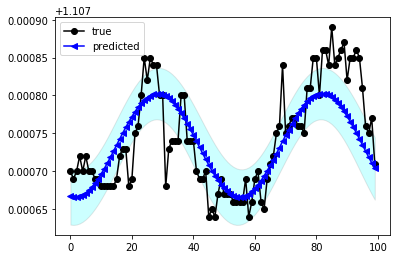

Optimization restart 1/50, f = -704.9377054096628
Optimization restart 2/50, f = -688.8499563699442
Optimization restart 3/50, f = -627.1170426831131
Optimization restart 4/50, f = -627.1668703840832
Optimization restart 5/50, f = -601.3608819545605
Optimization restart 6/50, f = -667.6439421613162
Optimization restart 7/50, f = -663.5007440135108
Optimization restart 8/50, f = -680.2804389528357
Optimization restart 9/50, f = -705.4374017560376
Optimization restart 10/50, f = -654.1602518571365
Optimization restart 11/50, f = -650.9362826341745
Optimization restart 12/50, f = -582.88754166872
Optimization restart 13/50, f = -689.9397981802593
Optimization restart 14/50, f = -645.0459380574783
Optimization restart 15/50, f = -595.8277432294676
Optimization restart 16/50, f = -704.1206427474325
Optimization restart 17/50, f = -583.1104073379034
Optimization restart 18/50, f = -621.2490651723148
Optimization restart 19/50, f = -690.522957938368
Optimization restart 20/50, f = -680.398115

Optimization restart 13/50, f = -627.4313437797101
Optimization restart 14/50, f = -718.4579398066708
Optimization restart 15/50, f = -723.1114862502906
Optimization restart 16/50, f = -721.9794730240515
Optimization restart 17/50, f = -721.9429360132317
Optimization restart 18/50, f = -688.0695529741303
Optimization restart 19/50, f = -678.2124982299174
Optimization restart 20/50, f = -698.5377329125264
Optimization restart 21/50, f = -721.8079507431289
Optimization restart 22/50, f = -689.1631230812558
Optimization restart 23/50, f = -687.5451964472709
Optimization restart 24/50, f = -722.6219983464665
Optimization restart 25/50, f = -721.8079368380354
Optimization restart 26/50, f = -721.942936424345
Optimization restart 27/50, f = -723.1114855848434
Optimization restart 28/50, f = -723.1114862148161
Optimization restart 29/50, f = -712.9682409101869
Optimization restart 30/50, f = -723.1114863406632
Optimization restart 31/50, f = -708.2183776308216
Optimization restart 32/50, f = 

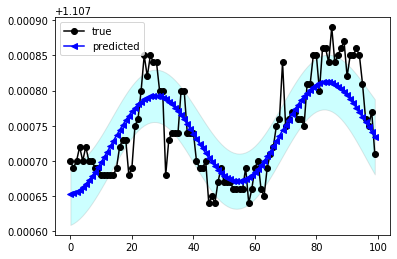

Optimization restart 1/50, f = -707.00255095616
Optimization restart 2/50, f = -406.30692594671495
Optimization restart 3/50, f = -142.48205030537036
Optimization restart 4/50, f = -700.2236178431906
Optimization restart 5/50, f = -262.244056044146
Optimization restart 6/50, f = -487.3769236481676
Optimization restart 7/50, f = -518.0608541880166
Optimization restart 8/50, f = -699.7598116825751
Optimization restart 9/50, f = -223.428659634277
Optimization restart 10/50, f = -689.7262944856918
Optimization restart 11/50, f = -421.62143528843893
Optimization restart 12/50, f = -360.6608645315848
Optimization restart 13/50, f = -326.73375025392113
Optimization restart 14/50, f = -667.385217253634
Optimization restart 15/50, f = -218.17245445641905
Optimization restart 16/50, f = -394.3585512185097
Optimization restart 17/50, f = 111.33543343724759
Optimization restart 18/50, f = -328.4596244587706
Optimization restart 19/50, f = -447.50719676270967
Optimization restart 20/50, f = -704.88

Optimization restart 13/50, f = -247.70868998076872
Optimization restart 14/50, f = -190.41103823808126
Optimization restart 15/50, f = -424.0179346127768
Optimization restart 16/50, f = -723.1114864409496
Optimization restart 17/50, f = -170.33590037066602
Optimization restart 18/50, f = -269.05003703363025
Optimization restart 19/50, f = -433.8847029311629
Optimization restart 20/50, f = -398.12731349997233
Optimization restart 21/50, f = -155.50098082279825
Optimization restart 22/50, f = -166.38681387551668
Optimization restart 23/50, f = -302.79764323003104
Optimization restart 24/50, f = -721.8079264067713
Optimization restart 25/50, f = -721.8234603483049
Optimization restart 26/50, f = -204.50973249987246
Optimization restart 27/50, f = -436.47872851234564
Optimization restart 28/50, f = -346.4997713344834
Optimization restart 29/50, f = -333.90617186576515
Optimization restart 30/50, f = -721.6971034816266
Optimization restart 31/50, f = -251.05344136808492
Optimization restar

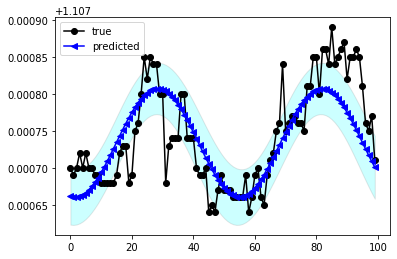

Optimization restart 1/50, f = -561.1781827418895
Optimization restart 2/50, f = -695.8602431892725
Optimization restart 3/50, f = -695.2905292332275
Optimization restart 4/50, f = -694.2310862980921
Optimization restart 5/50, f = -691.7045293685952
Optimization restart 6/50, f = -588.6667047556524
Optimization restart 7/50, f = -557.1376891120525
Optimization restart 8/50, f = -692.2841615251813
Optimization restart 9/50, f = -695.7254465384202
Optimization restart 10/50, f = -690.5250821591936
Optimization restart 11/50, f = -689.6380119581958
Optimization restart 12/50, f = -525.7306511097532
Optimization restart 13/50, f = -688.7149776561652
Optimization restart 14/50, f = -695.6776571745902
Optimization restart 15/50, f = -667.1418117229608
Optimization restart 16/50, f = -686.1653469287218
Optimization restart 17/50, f = -595.4871778994257
Optimization restart 18/50, f = -694.2457918969584
Optimization restart 19/50, f = -689.7374927821934
Optimization restart 20/50, f = -681.796

Optimization restart 15/50, f = -691.5544924325135
Optimization restart 16/50, f = -414.1236872245586
Optimization restart 17/50, f = -697.0118752971698
Optimization restart 18/50, f = -427.5095381713945
Optimization restart 19/50, f = -697.8160252659229
Optimization restart 20/50, f = -685.2232777846531
Optimization restart 21/50, f = -458.9453215345512
Optimization restart 22/50, f = -418.26438057817927
Optimization restart 23/50, f = -594.1081937046044
Optimization restart 24/50, f = -669.4833152733254
Optimization restart 25/50, f = -683.9699864783591
Optimization restart 26/50, f = -435.2586730350429
Optimization restart 27/50, f = -697.0119554576828
Optimization restart 28/50, f = -697.8160245993888
Optimization restart 29/50, f = -688.1657914023048
Optimization restart 30/50, f = -697.0112291424655
Optimization restart 31/50, f = -435.04259651572875
Optimization restart 32/50, f = -458.94532723254156
Optimization restart 33/50, f = -602.3137557292159
Optimization restart 34/50, 

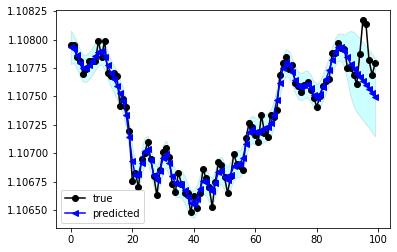

Optimization restart 1/50, f = -695.2971441747866
Optimization restart 2/50, f = -664.3614556809109
Optimization restart 3/50, f = -649.7007307888389
Optimization restart 4/50, f = -668.1450910376076
Optimization restart 5/50, f = -690.8177954941533
Optimization restart 6/50, f = -648.8642728819372
Optimization restart 7/50, f = -690.9820519874305
Optimization restart 8/50, f = -678.7315856608877
Optimization restart 9/50, f = -657.476267324242
Optimization restart 10/50, f = -690.3907995481434
Optimization restart 11/50, f = -690.903458453608
Optimization restart 12/50, f = -683.0150389615769
Optimization restart 13/50, f = -690.417877032355
Optimization restart 14/50, f = -693.4118865241147
Optimization restart 15/50, f = -681.041770191893
Optimization restart 16/50, f = -649.2485302947699
Optimization restart 17/50, f = -690.4178308087494
Optimization restart 18/50, f = -693.4118843280775
Optimization restart 19/50, f = -688.2387894352876
Optimization restart 20/50, f = -676.6798235

Optimization restart 13/50, f = -576.9884529548103
Optimization restart 14/50, f = -648.3208369087656
Optimization restart 15/50, f = -606.5212754787594
Optimization restart 16/50, f = -489.69793837381314
Optimization restart 17/50, f = -613.0688641915785
Optimization restart 18/50, f = -610.8055380698721
Optimization restart 19/50, f = -666.9330028424822
Optimization restart 20/50, f = -610.2123522025488
Optimization restart 21/50, f = -625.8023510758402
Optimization restart 22/50, f = -605.0675147268549
Optimization restart 23/50, f = -605.9488826485791
Optimization restart 24/50, f = -616.3272641917624
Optimization restart 25/50, f = -631.1948637568171
Optimization restart 26/50, f = -647.9828991861605
Optimization restart 27/50, f = -610.8055373533192
Optimization restart 28/50, f = -618.3524254694636
Optimization restart 29/50, f = -626.0456673251706
Optimization restart 30/50, f = -433.9391665014206
Optimization restart 31/50, f = -605.1099881834257
Optimization restart 32/50, f 

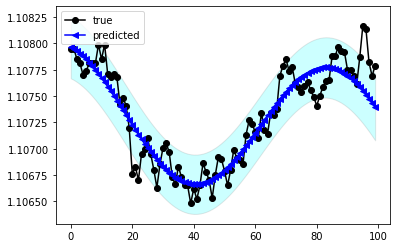

Optimization restart 1/50, f = -561.7558857501929
Optimization restart 2/50, f = -398.1944992116273
Optimization restart 3/50, f = -693.3628215773452
Optimization restart 4/50, f = -318.79570740684863
Optimization restart 5/50, f = -480.5571919891592
Optimization restart 6/50, f = -681.1242636475308
Optimization restart 7/50, f = -648.5002325921913
Optimization restart 8/50, f = -690.418299857544
Optimization restart 9/50, f = -646.902614689943
Optimization restart 10/50, f = -643.3330189514718
Optimization restart 11/50, f = -413.22743337534774
Optimization restart 12/50, f = -362.0483808777732
Optimization restart 13/50, f = -232.32000584958732
Optimization restart 14/50, f = -250.48058738117223
Optimization restart 15/50, f = -688.6516140958664
Optimization restart 16/50, f = -697.4495021829515
Optimization restart 17/50, f = -208.033910688851
Optimization restart 18/50, f = -181.34606569325754
Optimization restart 19/50, f = -397.6507039009393
Optimization restart 20/50, f = -675.0

Optimization restart 12/50, f = -560.017352144671
Optimization restart 13/50, f = -256.58512023237745
Optimization restart 14/50, f = -512.6820706750079


 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:155: RuntimeWarning:overflow encountered in true_divide


Optimization restart 15/50, f = -400.11334713619374
Optimization restart 16/50, f = -654.9812550971212
Optimization restart 17/50, f = -562.9460969853916
Optimization restart 18/50, f = -562.4966070145085
Optimization restart 19/50, f = -478.5529689738338
Optimization restart 20/50, f = -413.98630097933085
Optimization restart 21/50, f = -345.19946120369457
Optimization restart 22/50, f = -327.73623166219693
Optimization restart 23/50, f = -541.1585450073782
Optimization restart 24/50, f = -521.0710984633951
Optimization restart 25/50, f = -327.40835923384833
Optimization restart 26/50, f = -565.1459012657131
Optimization restart 27/50, f = -559.5850342402694
Optimization restart 28/50, f = -186.14424064017967
Optimization restart 29/50, f = -180.70033001302008
Optimization restart 30/50, f = -272.05273089095704
Optimization restart 31/50, f = -390.891249377551
Optimization restart 32/50, f = -485.53416671179775
Optimization restart 33/50, f = -609.9651099781249
Optimization restart 34

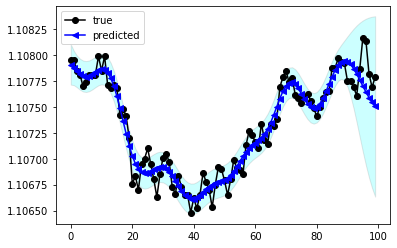

Optimization restart 1/50, f = -548.9131271649594
Optimization restart 2/50, f = -435.0706929767342
Optimization restart 3/50, f = -548.537689981225
Optimization restart 4/50, f = -436.48348735081703
Optimization restart 5/50, f = -548.644832800341
Optimization restart 6/50, f = -544.4961394706712
Optimization restart 7/50, f = -553.203752755276
Optimization restart 8/50, f = -552.3168851975428
Optimization restart 9/50, f = -438.17911017074465
Optimization restart 10/50, f = -548.7246778901379
Optimization restart 11/50, f = -465.3546669138993
Optimization restart 12/50, f = -550.0757016207745
Optimization restart 13/50, f = -535.3205603979586
Optimization restart 14/50, f = -505.43997426125213
Optimization restart 15/50, f = -514.130179227678
Optimization restart 16/50, f = -550.0757167309182
Optimization restart 17/50, f = -536.0939272062195
Optimization restart 18/50, f = -533.8196853335343
Optimization restart 19/50, f = -503.55585812857095
Optimization restart 20/50, f = -505.147

Optimization restart 13/50, f = -550.2878975010321
Optimization restart 14/50, f = -538.8891717435142
Optimization restart 15/50, f = -494.6344998028476
Optimization restart 16/50, f = -584.9369784683498
Optimization restart 17/50, f = -578.6120199149672
Optimization restart 18/50, f = -567.055171468135
Optimization restart 19/50, f = -505.76916043933977
Optimization restart 20/50, f = -570.3623750721683
Optimization restart 21/50, f = -586.3781387448067
Optimization restart 22/50, f = -576.8596708663263
Optimization restart 23/50, f = -565.8737792139148
Optimization restart 24/50, f = -583.7353453843336
Optimization restart 25/50, f = -586.3781383495412
Optimization restart 26/50, f = -508.8560674482909
Optimization restart 27/50, f = -322.698045792191
Optimization restart 28/50, f = -558.7191918743143
Optimization restart 29/50, f = -531.7144817566967
Optimization restart 30/50, f = -505.7692106950575
Optimization restart 31/50, f = -534.894250887948
Optimization restart 32/50, f = -

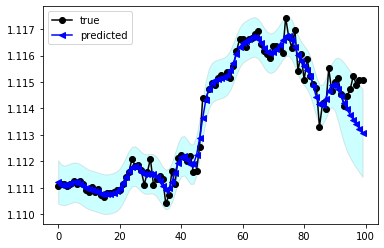

Optimization restart 1/50, f = -523.4805487594468
Optimization restart 2/50, f = -510.35988202004705
Optimization restart 3/50, f = -509.27957351618306
Optimization restart 4/50, f = -509.2211189640092
Optimization restart 5/50, f = -540.623295831211
Optimization restart 6/50, f = -508.8269428627374
Optimization restart 7/50, f = -509.2211190424573
Optimization restart 8/50, f = -508.19396498868116
Optimization restart 9/50, f = -517.4872928651993
Optimization restart 10/50, f = -463.508449815355
Optimization restart 11/50, f = -510.91234301399743
Optimization restart 12/50, f = -510.3598816845206
Optimization restart 13/50, f = -509.2093626339296
Optimization restart 14/50, f = -497.9559223537599
Optimization restart 15/50, f = -527.3518003504698
Optimization restart 16/50, f = -505.15088004906977
Optimization restart 17/50, f = -508.43429638141254
Optimization restart 18/50, f = -418.39059593723493
Optimization restart 19/50, f = -509.2094474212927
Optimization restart 20/50, f = -51

Optimization restart 12/50, f = -520.0091835832181
Optimization restart 13/50, f = -543.294782856197
Optimization restart 14/50, f = -485.89069879006433
Optimization restart 15/50, f = -514.5424190604488
Optimization restart 16/50, f = -474.503664363643
Optimization restart 17/50, f = -514.5424036601763
Optimization restart 18/50, f = 10.712304832801353
Optimization restart 19/50, f = -475.5597565590365
Optimization restart 20/50, f = -517.8171552557208
Optimization restart 21/50, f = -514.542411379018
Optimization restart 22/50, f = -514.5886749716273
Optimization restart 23/50, f = -426.559190000095
Optimization restart 24/50, f = -516.627882526275
Optimization restart 25/50, f = -518.4555785990259
Optimization restart 26/50, f = -530.5990471374336
Optimization restart 27/50, f = -514.5422762372821
Optimization restart 28/50, f = -493.4729334383163
Optimization restart 29/50, f = -521.7294561726937
Optimization restart 30/50, f = -514.542428452514
Optimization restart 31/50, f = -514

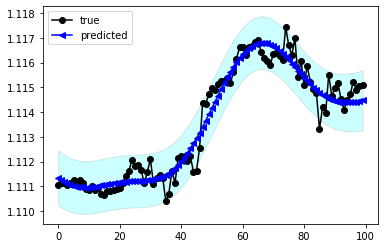

Optimization restart 1/50, f = -550.185475896818
Optimization restart 2/50, f = -473.3426308164306
Optimization restart 3/50, f = -434.09196869981173
Optimization restart 4/50, f = -331.16858978684286
Optimization restart 5/50, f = -356.4594010479074
Optimization restart 6/50, f = -458.4244931002439
Optimization restart 7/50, f = -517.7454867100427
Optimization restart 8/50, f = -397.0894154544024
Optimization restart 9/50, f = -496.13526914283
Optimization restart 10/50, f = -517.7275209399528
Optimization restart 11/50, f = -309.3258934636659
Optimization restart 12/50, f = -301.6916541575917
Optimization restart 13/50, f = -409.8371946935334
Optimization restart 14/50, f = -510.7837499615025
Optimization restart 15/50, f = -317.8096758251576
Optimization restart 16/50, f = -250.32730231865315
Optimization restart 17/50, f = -490.246092274533
Optimization restart 18/50, f = -210.64807210455515
Optimization restart 19/50, f = -349.201862656441
Optimization restart 20/50, f = -361.7861

Optimization restart 12/50, f = -425.2607349746478
Optimization restart 13/50, f = -378.1634226031284
Optimization restart 14/50, f = -376.73049290518634
Optimization restart 15/50, f = -203.42974923542533
Optimization restart 16/50, f = -464.60500542309694
Optimization restart 17/50, f = -175.58514458066975
Optimization restart 18/50, f = -253.87974766130225
Optimization restart 19/50, f = -397.84366971982854
Optimization restart 20/50, f = -481.17142315609135
Optimization restart 21/50, f = -393.5365455598189
Optimization restart 22/50, f = -457.9361498580422
Optimization restart 23/50, f = -486.5165721439889
Optimization restart 24/50, f = -419.4718757262871
Optimization restart 25/50, f = -512.3318344529503
Optimization restart 26/50, f = -358.3387874379472
Optimization restart 27/50, f = -317.9390380760292
Optimization restart 28/50, f = -475.8193196061093
Optimization restart 29/50, f = -522.0793218326168
Optimization restart 30/50, f = -158.39202258697725
Optimization restart 31

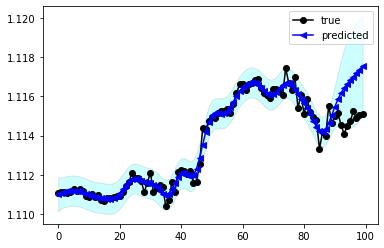

Optimization restart 1/50, f = -472.02179042762816
Optimization restart 2/50, f = -472.0241851239674
Optimization restart 3/50, f = -467.62274900744046
Optimization restart 4/50, f = -459.2087495299567
Optimization restart 5/50, f = -380.77638793734343
Optimization restart 6/50, f = -459.2087532655405
Optimization restart 7/50, f = -467.83873203498365
Optimization restart 8/50, f = -467.83873210190995
Optimization restart 9/50, f = -466.4443241946324
Optimization restart 10/50, f = -368.24489134116016
Optimization restart 11/50, f = -459.20873814139986
Optimization restart 12/50, f = -467.71338165235545
Optimization restart 13/50, f = -397.85543765062295
Optimization restart 14/50, f = -416.3772321100888
Optimization restart 15/50, f = -457.70313404976207
Optimization restart 16/50, f = -442.188279853114
Optimization restart 17/50, f = -467.8387321099573
Optimization restart 18/50, f = -388.4552491557556
Optimization restart 19/50, f = -456.7030967079024
Optimization restart 20/50, f =

Optimization restart 12/50, f = -389.477153715255
Optimization restart 13/50, f = -404.211296384594
Optimization restart 14/50, f = -421.5382896049142
Optimization restart 15/50, f = -405.53047788944923
Optimization restart 16/50, f = -429.5752587880376
Optimization restart 17/50, f = -420.28378708129367
Optimization restart 18/50, f = -424.20180109515456
Optimization restart 19/50, f = -424.45742027891
Optimization restart 20/50, f = -416.2981540371
Optimization restart 21/50, f = -418.73199191289956
Optimization restart 22/50, f = -424.86132413164285
Optimization restart 23/50, f = -417.009133111252
Optimization restart 24/50, f = -417.5014811433855
Optimization restart 25/50, f = -424.2017957643928
Optimization restart 26/50, f = -403.91008362657413
Optimization restart 27/50, f = -424.4993928242301
Optimization restart 28/50, f = -424.54624617041117
Optimization restart 29/50, f = -424.8657026955963
Optimization restart 30/50, f = -387.48330291312095
Optimization restart 31/50, f =

 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\standard_periodic.py:153: RuntimeWarning:overflow encountered in multiply


Optimization restart 19/50, f = -349.67208224054093
Optimization restart 20/50, f = -440.0849118192152
Optimization restart 21/50, f = -435.3871582877963
Optimization restart 22/50, f = -442.9957555945433
Optimization restart 23/50, f = -389.4009405203625
Optimization restart 24/50, f = -455.3382515300311
Optimization restart 25/50, f = -431.6383578272204
Optimization restart 26/50, f = -450.84670224590167
Optimization restart 27/50, f = -323.3724181486092
Optimization restart 28/50, f = -442.2675566022458
Optimization restart 29/50, f = -451.35189081650583
Optimization restart 30/50, f = -313.07405726485143
Optimization restart 31/50, f = -451.351890738583
Optimization restart 32/50, f = -450.8489652783603
Optimization restart 33/50, f = -455.33825155599783
Optimization restart 34/50, f = -380.64556466643285
Optimization restart 35/50, f = -445.58728009193953
Optimization restart 36/50, f = -455.04584789942635
Optimization restart 37/50, f = -444.9652676991328
Optimization restart 38/

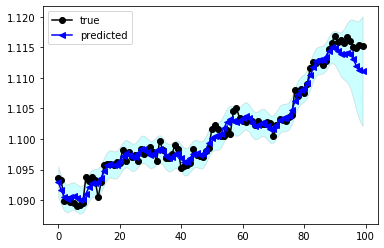

Optimization restart 1/50, f = -427.0330001491774
Optimization restart 2/50, f = -423.39082371554923
Optimization restart 3/50, f = -429.7082352445085
Optimization restart 4/50, f = -435.5143448768564
Optimization restart 5/50, f = -399.2105615887703
Optimization restart 6/50, f = -399.2105612936425
Optimization restart 7/50, f = -429.0765521356103
Optimization restart 8/50, f = -399.21081138957504
Optimization restart 9/50, f = -429.9547908944844
Optimization restart 10/50, f = -399.21056285978176
Optimization restart 11/50, f = -353.6164891973888
Optimization restart 12/50, f = -399.21055967637085
Optimization restart 13/50, f = -399.21057069725987
Optimization restart 14/50, f = -399.21080119664526
Optimization restart 15/50, f = -399.21057211010276
Optimization restart 16/50, f = -399.210576162027
Optimization restart 17/50, f = -381.6746230568314
Optimization restart 18/50, f = -399.2105146907448
Optimization restart 19/50, f = -409.17656884071255
Optimization restart 20/50, f = -

Optimization restart 12/50, f = -367.5659058378744
Optimization restart 13/50, f = -382.9622413077799
Optimization restart 14/50, f = -391.301503396126
Optimization restart 15/50, f = -383.36573203301344
Optimization restart 16/50, f = -379.83521732712387
Optimization restart 17/50, f = -357.6153987053522
Optimization restart 18/50, f = -380.8903669718038
Optimization restart 19/50, f = -388.33134285328043
Optimization restart 20/50, f = -357.39979006226037
Optimization restart 21/50, f = -364.73494937898784
Optimization restart 22/50, f = -401.1642305673897
Optimization restart 23/50, f = 63.581292042557536
Optimization restart 24/50, f = -392.5377757759967
Optimization restart 25/50, f = -391.6418480094803
Optimization restart 26/50, f = -383.6059530801052
Optimization restart 27/50, f = -383.36573099964704
Optimization restart 28/50, f = -362.770442389657
Optimization restart 29/50, f = -316.5445937356228
Optimization restart 30/50, f = -383.31846980308967
Optimization restart 31/50

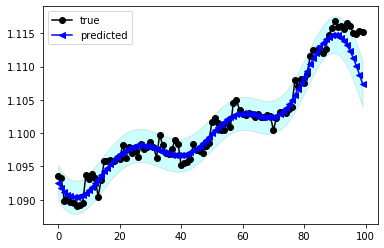

Optimization restart 1/50, f = -468.0046979126354
Optimization restart 2/50, f = -320.4754059277529
Optimization restart 3/50, f = -268.3458496763717
Optimization restart 4/50, f = -242.97108070139848
Optimization restart 5/50, f = -401.51933242249896
Optimization restart 6/50, f = -230.58788645815198
Optimization restart 7/50, f = -361.88800833664175
Optimization restart 8/50, f = -320.5821027072171
Optimization restart 9/50, f = -214.3010386254315
Optimization restart 10/50, f = -429.81177808916266
Optimization restart 11/50, f = -392.1907826565083
Optimization restart 12/50, f = -387.16844734737776
Optimization restart 13/50, f = -296.50290602760396
Optimization restart 14/50, f = -336.1206540157187
Optimization restart 15/50, f = -232.61747284735299
Optimization restart 16/50, f = -353.0970954585747
Optimization restart 17/50, f = -268.31002886175503
Optimization restart 18/50, f = -336.2647324473374
Optimization restart 19/50, f = -63.01822986677663
Optimization restart 20/50, f =

Optimization restart 12/50, f = -216.53087222594888
Optimization restart 13/50, f = -339.9762263877379
Optimization restart 14/50, f = -404.20237246872887
Optimization restart 15/50, f = -135.47672289871502
Optimization restart 16/50, f = -303.92926516729517
Optimization restart 17/50, f = -159.125997694132
Optimization restart 18/50, f = -402.95365048215496
Optimization restart 19/50, f = -244.54586104684765
Optimization restart 20/50, f = -371.6473119164435
Optimization restart 21/50, f = -382.212045068197
Optimization restart 22/50, f = 38.897665108883416
Optimization restart 23/50, f = -401.78363809544084
Optimization restart 24/50, f = -402.09036059732176
Optimization restart 25/50, f = -146.38782183283394
Optimization restart 26/50, f = -175.25969226767867
Optimization restart 27/50, f = -324.67506718752117
Optimization restart 28/50, f = -366.3272403295704
Optimization restart 29/50, f = -251.48294617067415
Optimization restart 30/50, f = -347.74283149642207
Optimization restart

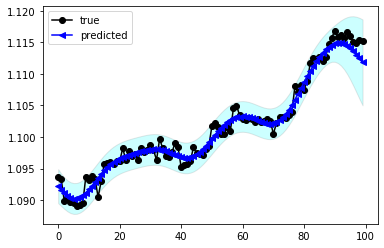

In [60]:
for p, i in enumerate(per):
    #data = con.get_candles('EUR/USD', period=i,number=500) # get data for specific period
    data = pd.read_csv('../'+i+'.csv')[:500]
    y=data['Open']
    Y = chunk(y, n)
    for k,j in enumerate(K):
        rms_t_plus_1[p, k], rms[p, k] = calcu_rmse(Y, j)

In [62]:
rms_new = (rms-rms.min())/(rms.max()-rms.min())

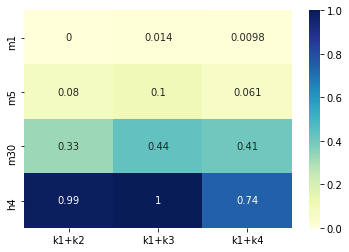

In [69]:
x_axis_labels = ['k1+k2','k1+k3','k1+k4']
y_axis_labels = ['m1','m5','m30','h4']
sns.heatmap(rms_new,annot=True,cmap="YlGnBu",xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [64]:
rms_t_plus_1_new = (rms_t_plus_1-rms_t_plus_1.min())/(rms_t_plus_1.max()-rms_t_plus_1.min())

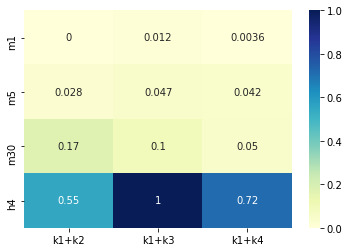

In [70]:
x_axis_labels = ['k1+k2','k1+k3','k1+k4']
y_axis_labels = ['m1','m5','m30','h4']
sns.heatmap(rms_t_plus_1_new,annot=True,cmap="YlGnBu",xticklabels=x_axis_labels, yticklabels=y_axis_labels)